In [144]:
#Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
!pip install yfinance
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

#Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#Warningleri kapatma
import warnings
warnings.filterwarnings("ignore")

#Tensorflow Warning Engelleme
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [145]:
# Başlangıç ve bitiş tarihlerini belirle
start_date = "2020-07-27"

# EREGL.IS hisse senedi verilerini çek
df = yf.Ticker("EREGL.IS").history(start=start_date,period="max",)

# Tarih sütununu oluştur
df['Date'] = df.index

# Tarih sütununu başa taşı ve index sütununu kaldır
df = df[['Date'] + [col for col in df.columns if col != 'Date']]
df.reset_index(drop=True, inplace=True)

* period="max": yazan parametreyi degistirerek ne kadar gecmisten data alacagimiz.("1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max")

* interval="1d": aldigimiz verilerin cozunurlugu.("1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo")

In [146]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-07-27 00:00:00+03:00,6.492081,6.569276,6.476642,6.538398,36658368,0.0,0.0
1,2020-07-28 00:00:00+03:00,6.538398,6.584714,6.237338,6.245058,52128832,0.0,0.0
2,2020-07-29 00:00:00+03:00,6.221900,6.268216,6.075229,6.098388,40853222,0.0,0.0
3,2020-07-30 00:00:00+03:00,6.090668,6.090668,5.897681,5.897681,20905330,0.0,0.0
4,2020-08-04 00:00:00+03:00,5.982595,6.098388,5.720133,5.982595,52747358,0.0,0.0


In [147]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [148]:
# En düşük fiyat ve tarihini bul
min_price_row = df[df['Low'] == df['Low'].min()]
min_price_date = min_price_row['Date'].iloc[0]
min_price = min_price_row['Low'].iloc[0]

# En yüksek fiyat ve tarihini bul
max_price_row = df[df['High'] == df['High'].max()]
max_price_date = max_price_row['Date'].iloc[0]
max_price = max_price_row['High'].iloc[0]

# Sonuçları göster
print(f"En Düşük Fiyatı: {min_price} TL, Tarihi: {min_price_date}")
print(f"En Yüksek Fiyatı: {max_price} TL, Tarihi: {max_price_date}")

En Düşük Fiyatı: 5.720133074210964 TL, Tarihi: 2020-08-04 00:00:00+03:00
En Yüksek Fiyatı: 53.54999923706055 TL, Tarihi: 2023-02-21 00:00:00+03:00


In [149]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
772,2023-08-28 00:00:00+03:00,44.119999,44.619999,43.779999,43.799999,145020115,0.0,0.0
773,2023-08-29 00:00:00+03:00,43.900002,44.320000,42.959999,43.160000,95639462,0.0,0.0
774,2023-08-31 00:00:00+03:00,43.459999,44.080002,43.020000,43.020000,104220436,0.0,0.0
775,2023-09-01 00:00:00+03:00,43.259998,44.299999,43.180000,44.060001,136716314,0.0,0.0
776,2023-09-04 00:00:00+03:00,44.500000,44.740002,44.419998,44.580002,14399225,0.0,0.0


In [150]:
df["Date"]=pd.to_datetime(df["Date"])

In [151]:
df.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
772,2023-08-28 00:00:00+03:00,44.119999,44.619999,43.779999,43.799999,145020115,0.0,0.0
773,2023-08-29 00:00:00+03:00,43.900002,44.320000,42.959999,43.160000,95639462,0.0,0.0
774,2023-08-31 00:00:00+03:00,43.459999,44.080002,43.020000,43.020000,104220436,0.0,0.0
775,2023-09-01 00:00:00+03:00,43.259998,44.299999,43.180000,44.060001,136716314,0.0,0.0
776,2023-09-04 00:00:00+03:00,44.500000,44.740002,44.419998,44.580002,14399225,0.0,0.0


In [152]:
eregli_df=df[["Date","Close"]]

In [153]:
eregli_df.head()

,Date,Close
0,2020-07-27 00:00:00+03:00,6.538398
1,2020-07-28 00:00:00+03:00,6.245058
2,2020-07-29 00:00:00+03:00,6.098388
3,2020-07-30 00:00:00+03:00,5.897681
4,2020-08-04 00:00:00+03:00,5.982595


In [154]:
eregli_df.index = eregli_df["Date"]

In [155]:
eregli_df.head()

,Date,Close
Date,,
2020-07-27 00:00:00+03:00,2020-07-27 00:00:00+03:00,6.538398
2020-07-28 00:00:00+03:00,2020-07-28 00:00:00+03:00,6.245058
2020-07-29 00:00:00+03:00,2020-07-29 00:00:00+03:00,6.098388
2020-07-30 00:00:00+03:00,2020-07-30 00:00:00+03:00,5.897681
2020-08-04 00:00:00+03:00,2020-08-04 00:00:00+03:00,5.982595


In [156]:
eregli_df.drop("Date",axis=1,inplace=True)

In [157]:
eregli_df.head()

,Close
Date,
2020-07-27 00:00:00+03:00,6.538398
2020-07-28 00:00:00+03:00,6.245058
2020-07-29 00:00:00+03:00,6.098388
2020-07-30 00:00:00+03:00,5.897681
2020-08-04 00:00:00+03:00,5.982595


In [158]:
eregli_df.tail()

,Close
Date,
2023-08-28 00:00:00+03:00,43.799999
2023-08-29 00:00:00+03:00,43.160000
2023-08-31 00:00:00+03:00,43.020000
2023-09-01 00:00:00+03:00,44.060001
2023-09-04 00:00:00+03:00,44.580002


In [159]:
result_df=eregli_df.copy()

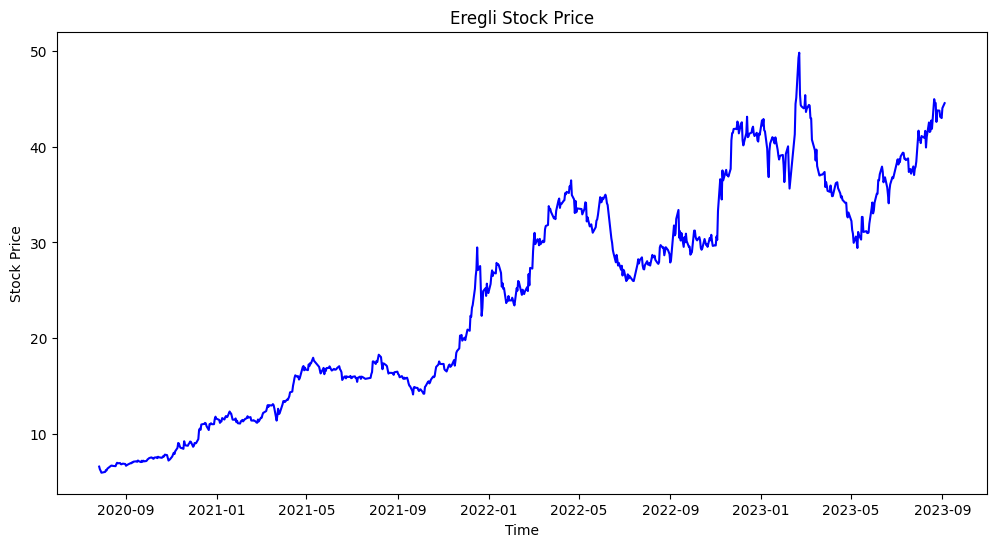

In [160]:
plt.figure(figsize=(12,6))
plt.plot(eregli_df["Close"],color="blue")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("Eregli Stock Price")
plt.show()

In [161]:
eregli_df=eregli_df.astype("float32")

In [162]:
#train-test ayrımının yapılması
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train,test,position

In [163]:
train,test,position=split_data(eregli_df,0.25)

In [164]:
print(train.shape,test.shape)

(583, 1) (194, 1)


In [165]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)

In [166]:
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)

In [167]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X),np.array(Y)

In [168]:
lookback=25

In [169]:
#Train Veri Seti
X_train,y_train=create_features(train,lookback)
#Test Veri Seti
X_test,y_test=create_features(test,lookback)

In [170]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(558, 25) (558,) (169, 25) (169,)


In [171]:
X_train[0:5]

array([[0.02014688, 0.010923  , 0.00631107, 0.        , 0.00267008,
        0.00849566, 0.00776747, 0.01335031, 0.01917593, 0.02136053,
        0.02305965, 0.02354512, 0.02257419, 0.02184598, 0.02160326,
        0.02815706, 0.03276898, 0.03106984, 0.03179805, 0.02815706,
        0.02767158, 0.02937073, 0.02985618, 0.02864252, 0.02281693],
       [0.010923  , 0.00631107, 0.        , 0.00267008, 0.00849566,
        0.00776747, 0.01335031, 0.01917593, 0.02136053, 0.02305965,
        0.02354512, 0.02257419, 0.02184598, 0.02160326, 0.02815706,
        0.03276898, 0.03106984, 0.03179805, 0.02815706, 0.02767158,
        0.02937073, 0.02985618, 0.02864252, 0.02281693, 0.02475879],
       [0.00631107, 0.        , 0.00267008, 0.00849566, 0.00776747,
        0.01335031, 0.01917593, 0.02136053, 0.02305965, 0.02354512,
        0.02257419, 0.02184598, 0.02160326, 0.02815706, 0.03276898,
        0.03106984, 0.03179805, 0.02815706, 0.02767158, 0.02937073,
        0.02985618, 0.02864252, 0.02281693, 0.

In [172]:
y_train[0:5]

array([0.02475879, 0.0262152 , 0.02767158, 0.03131258, 0.03106984],
      dtype=float32)

In [173]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [174]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(558, 1, 25) (558, 1) (169, 1, 25) (169, 1)


In [175]:
model=Sequential()
model.add(LSTM(units=50,
               activation="relu",
               input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [176]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                15200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15,251
Trainable params: 15,251
Non-trainable params: 0
_________________________________________________________________


In [177]:
#Optizimasyon ve Değerlendirme Metriklerinin ayarlanması
#Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss="mean_squared_error",optimizer="adam")

callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),#patience->3 tekrarda da ilerleme olmazsa dur
           ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                           save_best_only=True,save_weight_only=False,verbose=1)]

In [178]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
27/28 [===========================>..] - ETA: 0s - loss: 0.0374
Epoch 1: val_loss improved from inf to 0.02480, saving model to mymodel.h5
28/28 [==============================] - 2s 18ms/step - loss: 0.0370 - val_loss: 0.0248
Epoch 2/100
15/28 [===============>..............] - ETA: 0s - loss: 0.0034
Epoch 2: val_loss did not improve from 0.02480
28/28 [==============================] - 0s 5ms/step - loss: 0.0219 - val_loss: 0.0266
Epoch 3/100
13/28 [============>.................] - ETA: 0s - loss: 0.0059    
Epoch 3: val_loss improved from 0.02480 to 0.02266, saving model to mymodel.h5
28/28 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0227
Epoch 4/100
15/28 [===============>..............] - ETA: 0s - loss: 0.0022
Epoch 4: val_loss did not improve from 0.02266
28/28 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0232
Epoch 5/100
28/28 [==============================] - ETA: 0s - loss: 0.0145
Epoch 5: val_loss i

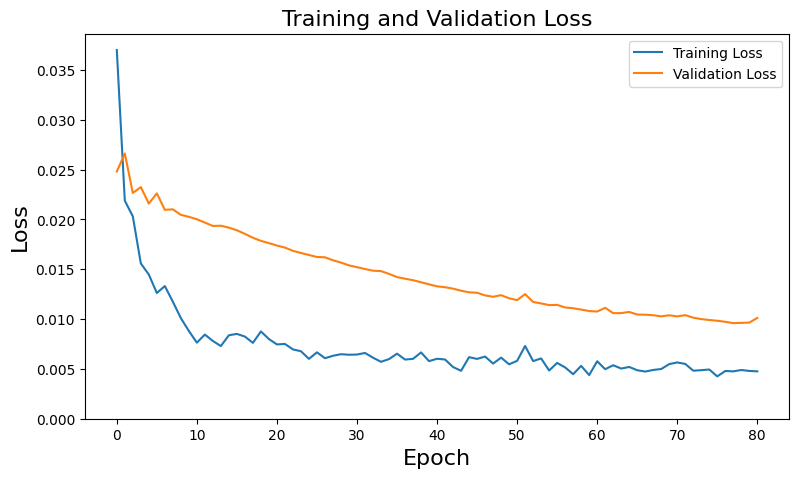

In [179]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()
#loss=mse

In [180]:
loss = model.evaluate(X_test,y_test,batch_size=20)
print("\nTest loss:%.1f%%"%(100.0*loss))

9/9 [==============================] - 0s 3ms/step - loss: 0.0101

Test loss:1.0%


In [181]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 3ms/step


In [182]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)

In [183]:
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

In [184]:
#Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [185]:
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict))

In [186]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 1.7710583209991455
Test RMSE: 2.055203914642334


In [187]:
train_prediction_df=result_df[lookback:position]
train_prediction_df["Predicted"]=train_predict
train_prediction_df.head()

,Close,Predicted
Date,,
2020-09-02 00:00:00+03:00,6.685068,8.751788
2020-09-03 00:00:00+03:00,6.731385,8.751788
2020-09-04 00:00:00+03:00,6.777701,8.751788
2020-09-07 00:00:00+03:00,6.893494,8.751788
2020-09-08 00:00:00+03:00,6.885774,8.751788


In [188]:
test_prediction_df=result_df[position+lookback:]
test_prediction_df["Predicted"]=test_predict
test_prediction_df.head()

,Close,Predicted
Date,,
2022-12-27 00:00:00+03:00,40.680000,40.578915
2022-12-28 00:00:00+03:00,40.560001,40.417244
2022-12-29 00:00:00+03:00,41.400002,40.421360
2022-12-30 00:00:00+03:00,41.259998,40.384583
2023-01-02 00:00:00+03:00,42.779999,40.177807


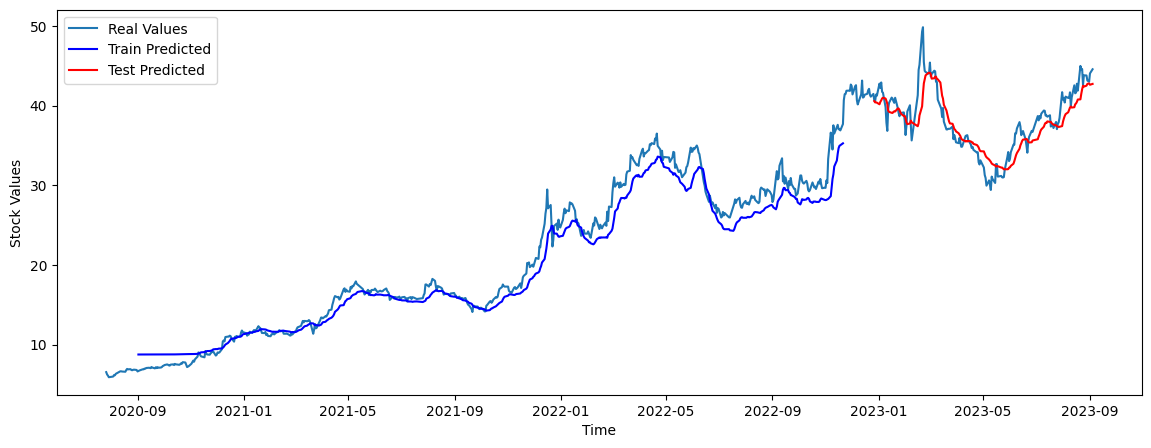

In [189]:
plt.figure(figsize=(14,5))
plt.plot(result_df,label="Real Values")
plt.plot(train_prediction_df["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_df["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()

In [190]:
# 4 Eylül için tahmin yapmak istiyorsanız, o tarihten önceki 30 günlük veriyi kullanın
input_data = eregli_df["Close"].values[-lookback:]
input_data = scaler_test.transform(input_data.reshape(-1, 1))

# Veriyi uygun şekilde yeniden şekillendirin
input_data = input_data.reshape(1, 1, lookback)

# Tahmini alın
predicted_price = model.predict(input_data)

# Tahmini tersine dönüştürün
predicted_price = scaler_test.inverse_transform(predicted_price)

# Tahmin edilen fiyatı yazdırın
print("4 Eylül için tahmin edilen kapanış fiyatı:", predicted_price[0][0])


1/1 [==============================] - 0s 28ms/step
4 Eylül için tahmin edilen kapanış fiyatı: 42.650124
